

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindsaygross/mechanistic-interpretability/blob/main/mechanistic-interpretability.ipynb)


# Mechanistic Interpretability Assignment



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np, random, string, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

torch.manual_seed(0); random.seed(0); np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Data Generation

In [8]:
ALPHABET = list(string.ascii_uppercase)
VOWELS = set("AEIOU")
SEQ_LEN = 4
ALPH = 26
INPUT_DIM = SEQ_LEN * ALPH

def one_hot_word(word):
    x = np.zeros((SEQ_LEN, ALPH), dtype=np.float32)
    for i,ch in enumerate(word):
        x[i, ord(ch)-65] = 1.0
    return x.reshape(-1)

def make_dataset(n):
    X, y, words = [], [], []
    for _ in range(n):
        w = "".join(random.choice(ALPHABET) for _ in range(SEQ_LEN))
        X.append(one_hot_word(w))
        y.append(int(any(c in VOWELS for c in w)))
        words.append(w)
    X = torch.tensor(np.stack(X), dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    return X, y, words

X_train, y_train, _ = make_dataset(6000)
X_val,   y_val,   _ = make_dataset(1000)
X_test,  y_test,  _ = make_dataset(1000)

X_train, y_train = X_train.to(device), y_train.to(device)
X_val,   y_val   = X_val.to(device),   y_val.to(device)
X_test,  y_test  = X_test.to(device),  y_test.to(device)


### Build a Tiny MLP (multilayer perceptron) Model

In [10]:
# Define neural network class
class VowelMLP(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, hidden=12):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out, h

model = VowelMLP().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-3)
loss_fn = nn.BCELoss()


### TRAIN

In [11]:
def batches(X, y, bs=256):
    idx = torch.randperm(len(X), device=X.device)
    for i in range(0, len(idx), bs):
        j = idx[i:i+bs]
        yield X[j], y[j]

for epoch in range(8):
    model.train()
    for xb, yb in batches(X_train, y_train):
        opt.zero_grad()
        p, _ = model(xb)
        loss = loss_fn(p, yb)
        loss.backward(); opt.step()
    model.eval()
    with torch.no_grad():
        pv, _ = model(X_val)
    acc = ((pv>0.5).float()==y_val).float().mean().item()
    print(f"epoch {epoch+1} val_acc {acc:.3f}")


epoch 1 val_acc 0.722
epoch 2 val_acc 0.876
epoch 3 val_acc 0.997
epoch 4 val_acc 1.000
epoch 5 val_acc 1.000
epoch 6 val_acc 1.000
epoch 7 val_acc 1.000
epoch 8 val_acc 1.000


# TEST

In [12]:
model.eval()
with torch.no_grad():
    pt, H_test = model(X_test)
yhat = (pt>0.5).float()
test_acc = (yhat==y_test).float().mean().item()
print("test_acc", round(test_acc,3))


test_acc 1.0


# Explore internals

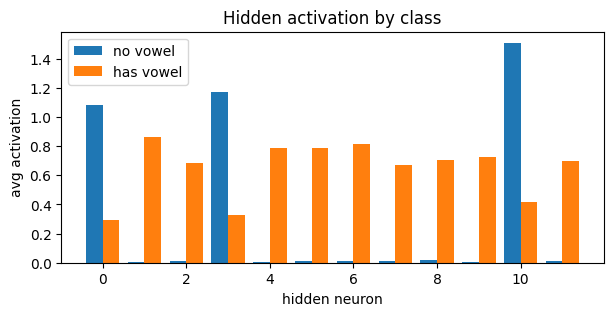

candidate vowel neuron: 1


In [13]:
H = H_test.detach().cpu().numpy()
yv = y_test.cpu().numpy().ravel().astype(int)
avg_no  = H[yv==0].mean(axis=0)
avg_yes = H[yv==1].mean(axis=0)

plt.figure(figsize=(7,3))
i = np.arange(len(avg_no))
plt.bar(i-0.2, avg_no, width=0.4, label="no vowel")
plt.bar(i+0.2, avg_yes, width=0.4, label="has vowel")
plt.xlabel("hidden neuron"); plt.ylabel("avg activation"); plt.legend(); plt.title("Hidden activation by class")
plt.show()

key_neuron = int(np.argmax(avg_yes - avg_no))
print("candidate vowel neuron:", key_neuron)


# Letter selectivity

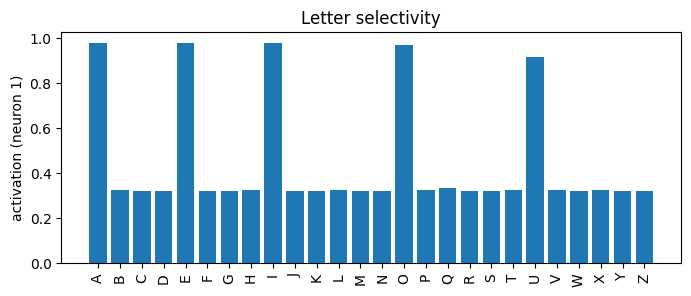

In [14]:
def encode_single_letter(letter, pos):
    x = np.zeros((SEQ_LEN, ALPH), dtype=np.float32)
    x[pos, ord(letter)-65] = 1.0
    return torch.tensor(x.reshape(-1), dtype=torch.float32, device=device).unsqueeze(0)

acts = []
model.eval()
with torch.no_grad():
    for L in ALPHABET:
        pos_acts = []
        for pos in range(SEQ_LEN):
            _, h = model(encode_single_letter(L, pos))
            pos_acts.append(h[0, key_neuron].item())
        acts.append(np.mean(pos_acts))
acts = np.array(acts)

plt.figure(figsize=(8,3))
plt.bar(range(26), acts)
plt.xticks(range(26), ALPHABET, rotation=90)
plt.ylabel(f"activation (neuron {key_neuron})"); plt.title("Letter selectivity")
plt.show()


# Position tuning for vowel

In [ ]:
# Position tuning for one vowel (e.g., 'A')
def pos_tuning(letter='A'):
    vals = []
    with torch.no_grad():
        for pos in range(SEQ_LEN):
            x = torch.zeros((1, SEQ_LEN, ALPH), dtype=torch.float32, device=device)
            x[0, pos, ord(letter) - 65] = 1.0
            _, h = model(x.view(1, -1))
            vals.append(h[0, key_neuron].item())
    return vals

plt.figure(figsize=(5,3))
plt.plot(range(SEQ_LEN), pos_tuning('A'), marker='o')
plt.xlabel("position")
plt.ylabel(f"neuron {key_neuron} activation")
plt.title("Position tuning for 'A'")
plt.show()


# Accuracy drop

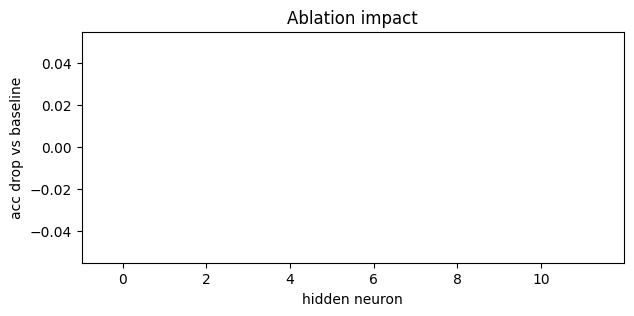

worst ablation neuron: 0


In [15]:
def ablate_accuracy(neuron_idx):
    model.eval()
    with torch.no_grad():
        h = F.relu(model.fc1(X_test))
        h[:, neuron_idx] = 0.0
        p = torch.sigmoid(model.fc2(h))
        return ((p>0.5).float()==y_test).float().mean().item()

baseline = test_acc
drop_per_neuron = []
for j in range(model.fc1.out_features):
    acc_j = ablate_accuracy(j)
    drop_per_neuron.append(baseline - acc_j)

plt.figure(figsize=(7,3))
plt.bar(range(len(drop_per_neuron)), drop_per_neuron)
plt.xlabel("hidden neuron"); plt.ylabel("acc drop vs baseline")
plt.title("Ablation impact")
plt.show()

print("worst ablation neuron:", int(np.argmax(drop_per_neuron)))


# Positive class accuracy drop

In [ ]:
# Check accuracy drop specifically for vowel-containing words
with torch.no_grad():
    base_p, _ = model(X_test)
base_pred = (base_p > 0.5).float().cpu().numpy().ravel()
pos_mask = (y_test.cpu().numpy().ravel() == 1)

def ablate_pos_acc(j):
    with torch.no_grad():
        h = F.relu(model.fc1(X_test))
        h[:, j] = 0
        p = torch.sigmoid(model.fc2(h))
    pred = (p > 0.5).float().cpu().numpy().ravel()
    # measure accuracy on vowel-positive subset
    return (pred[pos_mask] == base_pred[pos_mask]).mean()

pos_acc_drop = 1 - ablate_pos_acc(key_neuron)
print(f"Pos-class accuracy drop when ablating neuron {key_neuron}: {pos_acc_drop:.3f}")


# Weight map

In [ ]:
# Visualize first-layer weights feeding into the vowel neuron
W = model.fc1.weight.detach().cpu().numpy().reshape(-1, SEQ_LEN, ALPH)
plt.figure(figsize=(8,3))
plt.imshow(W[key_neuron], aspect='auto')
plt.yticks(range(SEQ_LEN), [f"pos {p}" for p in range(SEQ_LEN)])
plt.xticks(range(ALPH), list(string.ascii_uppercase), rotation=90)
plt.title(f"Input weights into neuron {key_neuron}")
plt.colorbar()
plt.show()


#### **What does this plot show us?**

##### *Neuron Specialization*
Look for rows (neurons) that are brightest at specific counts.

If a neuron appears consistently dark, that could mean it is unused or suppressed.

##### *Monotonic Trends*
If neurons show a gradual increase in activation with count — they may be learning a linear or thresholded count pattern.

That’s a great example of linearly increasing features often discussed in mechanistic interpretability (e.g. linear probe-ability).

##### *Redundant or Silent Units*
Some neurons may appear flatlined which possibly means they are unused due to redundancy. *What happens if you remove the neuron entirely?*

##### *Activation Superposition*
Some neurons activate across a range of counts, possibly blending multiple input features — this ties into superposition theory (see: Toy Models of Superposition)

_____________________

#### **What does the ablation tell us?**

If the prediction changes significantly after zeroing out a neuron, that neuron likely plays an important functional role in the model’s decision!

### Neuron Ablation (sweep of neurons)

#### **What does the sweep of neuron ablations tell us?**

Which neurons had the most impact on predictions?

Are there redundant neurons (zeroing them causes no change)?